# Qiskit Coding Exercise: Solving Max-Cut with QAOA

This notebook is a hands-on exercise to implement the QAOA algorithm described in your notes. You will follow the 7-step process to define, solve, and verify the solution for a classical Max-Cut problem.

## Setup: Imports

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence
from qiskit import QuantumCircuit
 
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

--- 

## Task 1: Define the Problem (The Graph)

### 1. Engage (Why?)
We start with a classical optimization problem. The Max-Cut problem is the "Hello, World!" of quantum optimization. Our goal is to find a way to partition the nodes of a graph into two sets (0 and 1) to *maximize* the number of edges connecting the two sets.

### 2. Explore (Play)
Let's use a simple 5-node graph (a square) with 4 edges. We can draw it to visualize.



### 3. Explain (The Concept)
We can create this graph using the `networkx` library. The nodes will be labeled 0, 1, 2, 3 and 4.

### 4. Elaborate (Apply)
Run the code below to create and draw our problem graph.

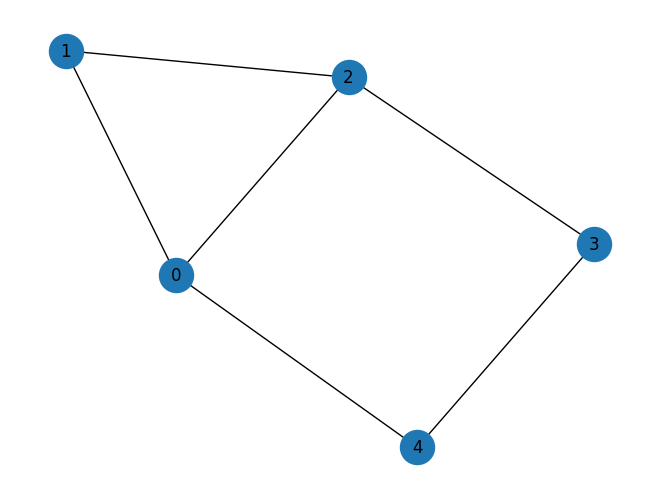

In [3]:
n = 5

graph = rx.PyGraph()
graph.add_nodes_from(np.arange(0, n, 1))
edge_list = [
    (0, 1, 1.0),
    (0, 2, 1.0),
    (0, 4, 1.0),
    (1, 2, 1.0),
    (2, 3, 1.0),
    (3, 4, 1.0),
]
graph.add_edges_from(edge_list)
draw_graph(graph, node_size=600, with_labels=True)

### 5. Evaluate (Verification)

Before we use a quantum computer, **what is the *classical* solution?** 

Look at the graph. A bitstring like `00000` or `11111` gives 0 cuts (bad solution).
A bitstring like `00101` puts nodes 0, 1 and 3 in set '0' and nodes 2 and 4 in set '1'. This cuts all 5 edges. This is a probable optimal solution.

**Ground Truth (Optimal Solutions):**

Our goal is to make the QAOA algorithm return the optimal solutions

--- 

## Task 2: Create the Cost Hamiltonian $H_P$

### 1. Engage (Why?)
Now we translate our classical graph into a quantum physics problem. We will build the Cost Hamiltonian $H_P$.

### 2. Explain (The Concept)
As derived in your notes, the Cost Hamiltonian for Max-Cut is $H_P = \sum_{(i, j) \in \text{edges}} Z_i Z_j$. 

We will build this operator using Qiskit's `SparsePauliOp` class. We loop through each edge in our graph `graph` and add a 'ZZ' term for that edge.

For our 5-qubit graph, the edges are `(0, 1)`, `(0, 2)`, `(0, 4)`, `(1, 2)`, `(2, 3)`, and `(3, 4)`. The `SparsePauliOp` list will be: `['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII']`. (Remember, Qiskit orders qubits from right to left `[43210]`).

In [8]:
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZ', 'IIZIZ', 'ZIIIZ', 'IIZZI', 'IZZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


### 3. Evaluate (Verify with Simulation)
Let's verify this Hamiltonian is correct *before* we build the algorithm. We can use the `Estimator` primitive to check the energy of our known good and bad solutions.

**Your Task:** Create two circuits, one for a bad solution (`'00000'`) and one for a good solution (`'00101'`). Then, use the `Estimator` to find the cost (energy) of each. 

*(Remember to apply X gates to create the `|1
angle` states for `'00101'`).*

In [11]:
# --- Your Code Here ---

# 1. Create the 'bad' circuit (00000) - No cuts
# An empty circuit on n=5 qubits naturally prepares the |00000> state
qc_bad = QuantumCircuit(n) 

# 2. Create the 'good' circuit (00101) - Optimal cut
# We want the state |00101>. In Qiskit (little-endian), this means:
# q0 = 1, q1 = 0, q2 = 1, q3 = 0, q4 = 0
qc_good = QuantumCircuit(n)
qc_good.x(0) # Flip q0 to |1>
qc_good.x(2) # Flip q2 to |1>

# 3. Instantiate an Estimator (V2)
estimator = Estimator()              # local, ideal reference estimator
job = estimator.run(circuits=[qc_bad, qc_good], observables=[cost_hamiltonian, cost_hamiltonian])
res = job.result()
print("Estimator results (expectation values):", res.values)  # list of floats

# 4. Run the Estimator
# The V2 Estimator takes a list of "Primitive Unified Blocs" (PUBs).
# Each PUB is a tuple: (circuit, observable)
# We don't need parameters here because these circuits have fixed gates (X).
pub_bad = (qc_bad, cost_hamiltonian)
pub_good = (qc_good, cost_hamiltonian)

job = estimator.run([pub_bad, pub_good])
result = job.result()

# 5. Extract results
# The V2 result object contains an array of data for each PUB submitted.
# .data.evs gets the Expectation Values
cost_bad = result[0].data.evs
cost_good = result[1].data.evs

print(f"Energy of '00000' (Bad): {cost_bad}")
print(f"Energy of '00101' (Good): {cost_good}")

# --- End Your Code ---

AccountNotFoundError: 'Unable to find account.'

**Analysis:** You should see that the bad solution has an energy of +4.0 (all 4 edges are uncut, `+1` cost each), and the good solution has an energy of -4.0 (all 4 edges are cut, `-1` cost each). Our Hamiltonian is correct!

--- 

## Task 3: Build the QAOA Ansatz $U(\vec{\theta})$

*(Corresponds to Step 3 in your notes)*

### 1. Engage (Why?)
Now we build the parameterized quantum circuit (the Ansatz). This circuit will be trained to *find* the ground state of $H_P$.

### 2. Explain (The Concept)
As defined in your notes (Section 4), the ansatz is built from $p$ layers of the Cost Layer and the Mixer Layer.
* **Cost Layer:** $U_P(\gamma_i) = \prod e^{-i\gamma_i Z_i Z_j}$ -> `qc.rzz(2 * gamma, i, j)`
* **Mixer Layer:** $U_M(\beta_i) = \prod e^{-i\beta_i X_i}$ -> `qc.rx(2 * beta, i)`

We will use Qiskit's `ParameterVector` to create the variables $\vec{\theta} = (\gamma_0, \beta_0, \gamma_1, \beta_1, \dots)$.

### 3. Elaborate (Apply)
**Your Task:** Complete the `create_qaoa_ansatz` function below. We will set $p=1$ for this first example, so there are two parameters: $\gamma_0$ and $\beta_0$.

In [ ]:
p = 1 # Number of layers
# Create a list of 2*p parameters (gammas and betas)
params = ParameterVector('θ', 2 * p)

def create_qaoa_ansatz(p, graph, params):
    n = graph.number_of_nodes()
    qc = QuantumCircuit(n)
    
    # --- Your Code Here --- 
    
    # 1. Start in superposition
    qc.h(range(n))
    qc.barrier()
    
    # Loop through p layers
    for i in range(p):
        # 2. Apply Cost Layer U_P(gamma_i)
        gamma = params[2*i]
        for (u, v) in graph.edges():
            qc.rzz(2 * gamma, u, v)
        qc.barrier()
        
        # 3. Apply Mixer Layer U_M(beta_i)
        beta = params[2*i+1]
        qc.rx(2 * beta, range(n))
        qc.barrier()
        
    # --- End Your Code --- 
    
    return qc

# Build and draw the ansatz for p=1
ansatz = create_qaoa_ansatz(p, G, params)
print(f"QAOA Ansatz with p={p} layers:")
ansatz.draw('mpl')

--- 

## Task 4: Run the Hybrid Loop

*(Corresponds to Steps 4, 5, & 6 in your notes)*

### 1. Engage (Why?)
We have the Hamiltonian ($H_P$) and the Ansatz ($U(\vec{\theta})$). Now we need to find the *best* $\vec{\theta}$. We will use a classical optimizer to "train" the circuit by running the hybrid loop.

### 2. Explain (The Concept)
We will use the **`SPSA`** optimizer. 

**CRITICAL FIX for Qiskit Algorithms:** The `SPSA` optimizer in the `qiskit-algorithms` library does not accept an `args` parameter to pass extra data (like the ansatz and Hamiltonian) to the cost function. We must use a Python `lambda` function to wrap our cost function into a single-argument function that the optimizer can use.

In [ ]:
# 4.A. Choose the Classical Optimizer
optimizer = SPSA(maxiter=100)

# 4.B. Define the "Cost Function"
# This function is what the optimizer will call at each step
def cost_function(params_values, ansatz, hamiltonian, estimator):
    """Runs the ansatz and returns the measured cost."""
    # estimator.run() expects a list of circuits and a list of observables
    # or single objects. It returns a job.
    job = estimator.run([ansatz], [hamiltonian], parameter_values=[params_values])
    result = job.result()
    cost = result.values[0]
    return cost

print("Optimizer and Cost Function defined.")

### 3. Elaborate (Apply)
**Your Task:** Run the optimization loop! We'll start the optimizer with a random initial guess for the parameters. We will wrap the `cost_function` so `SPSA` can call it.

In [ ]:
# --- Your Code Here --- 

# 1. Create an initial random guess for the parameters (gammas and betas)
np.random.seed(42) # for reproducibility
initial_point = np.random.rand(2 * p)

print(f"Running optimization for p={p} layers...")

# 2. Wrap the cost function
# This creates a function 'objective' that takes ONLY 'theta' as input,
# which is what SPSA expects.
objective = lambda theta: cost_function(theta, ansatz, H_P, estimator)

# 3. Run the optimizer.minimize() function
opt_result = optimizer.minimize(
    fun=objective,          # The wrapped cost function
    x0=initial_point        # The initial parameter guess
)

print("\nOptimization complete.")
print(f"Best Cost Found: {opt_result.fun:.4f}")
print(f"Best Parameters (theta): {opt_result.x}")

best_params = opt_result.x

# --- End Your Code ---

**Analysis:** The optimizer should find a cost very close to **-4.0**, which we know is the energy of the *correct* solution. Now, let's find the bitstring that gives this cost.

--- 

## Task 5: Get and Verify the Final Solution

*(Corresponds to Step 7 in your notes)*

### 1. Engage (Why?)
The optimizer gives us the best *parameters* (angles), not the final bitstring. We must run our circuit one last time with these best parameters to find the solution.

### 2. Explain (The Concept)
As your notes (Sec 5.A) state, we now use the **`Sampler`** primitive. The `Sampler` runs the optimized circuit and returns the probabilities of measuring each bitstring. 

**Note:** The reference `Sampler` calculates exact quasi-probabilities by default (ideal simulation), so we do not need to specify a number of `shots`.

In [ ]:
# --- Your Code Here --- 

# 1. Assign the best parameters to the ansatz
optimized_circuit = ansatz.assign_parameters(best_params)
# We need to measure the circuit to get bitstrings
optimized_circuit.measure_all()

# 2. Create a Sampler
sampler = Sampler()

# 3. Run the Sampler
job = sampler.run(optimized_circuit)
result = job.result()
counts = result.quasi_dists[0].binary_probabilities()

print("Sampling complete.")

# --- End Your Code ---

# 4. Plot the results
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.xlabel("Bitstring (Solution)")
plt.ylabel("Probability")
plt.title(f"QAOA Solution for p={p} layer")
plt.xticks(rotation=70)
plt.show()

### 4. Evaluate (Final Verification)

Look at your plot. The two bitstrings with the highest probabilities should be **`0101`** and **`1010`**. 

This confirms our "Ground Truth" from Task 1. The QAOA algorithm has successfully used quantum mechanics to find the optimal solution to the Max-Cut problem!